In [ ]:
#all_slow

In [ ]:
#hide
from nbdev.showdoc import *

# Tutorial: Sequence Classification Tuning
> A tutorial following the fine-tuning and data API for Sequence Classification

In [ ]:
from adaptnlp.training.data import SequenceClassificationDatasets, ColReader, RandomSplitter
from adaptnlp.training.tuner import SequenceClassificationTuner

## Overview
In this tutorial we will cover building a dataset with the AdaptNLP data API for Sequence Classification, and fine-tuning a model towards that dataset. 

Throughout the tutorial you will notice we call from `fastai`, this is because the tuning API is built upon their library 

> Note: Eventually this will change to `fastai_minima`

For our task, we will use the `IMDB_SAMPLE` dataset to help us tune a BERT model

## Building the Dataset

The first thing we need to do is get some data. We will use fastai's handy `untar_data` function and `URLs` class to download it:

In [ ]:
from fastai.data.external import untar_data, URLs

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE); path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

As you can see, we get a `Path` object showing where the data is stored. Let's open it in `pandas`, as currently the API only supports reading in through `DataFrame`'s:

In [ ]:
import pandas as pd

df = pd.read_csv(path/'texts.csv')

In [ ]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


So we have a `label`, some `text`, and an `is_valid` column. Let's see how we can frame this into an AdaptNLP `SequenceClassificationDatasets`. 

We'll use the `SequenceClassificationDatasets.from_df` helper function:

In [ ]:
help(SequenceClassificationDatasets.from_df)

Help on method from_df in module adaptnlp.training.data:

from_df(df: Union[pandas.core.frame.DataFrame, pathlib.Path], text_col: str = 'text', label_col: str = 'labels', splits=None, tokenizer_name: str = None, tokenize: bool = True) method of builtins.type instance
    Builds `SequenceClassificationDatasets` from a `DataFrame` or file path



As we can see, it expects a `DataFrame`, a text column name our text is stored at, a label column name, splits, and a tokenizer model.

First let's look at how to write our splits. 

These should be in the format of a list of indicies, dictating what goes to the training, and what goes to the validation sets such as: `[[0,1,2],[3,4,5]]`.

Since we have an `is_valid` column, we will bring in `fastai`'s `ColSplitter`, which can read in that `is_valid` column and generate some indicies:

In [ ]:
from fastai.data.transforms import ColSplitter

splits = ColSplitter('is_valid')(df)

In [ ]:
splits

((#800) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

We can see that 800 indicies went to `[0]`, and 200 indicies went to `[1]`. Now that we have some splits, let's build and tokenize our dataset:

In [ ]:
dset = SequenceClassificationDatasets.from_df(
    df = df,
    text_col = 'text',
    label_col = 'label',
    splits = splits,
    tokenizer_name = 'bert-base-uncased',
    tokenize = True
)

Once we have our tokenized `Dataset`, all we need to do is build our `DataLoaders`:

In [ ]:
dls = dset.dataloaders(batch_size=8, shuffle_train=True)

Let's make sure a batch looks okay:

In [ ]:
next(iter(dls[0]))

{'input_ids': tensor([[ 101, 1045, 2788,  ...,    0,    0,    0],
        [ 101, 1045, 2323,  ..., 2965, 1012,  102],
        [ 101, 1045, 4669,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 3185,  ...,    0,    0,    0],
        [ 101, 1045, 2387,  ...,    0,    0,    0],
        [ 101, 5525, 1037,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 1, 1, 1, 0, 0, 1])}

Looks great! Next let's move onto our Tuning:

## Tuning a Model

Next we need to tune a model to our dataset! For this we will use the `SequenceClassificationTuner`, which has some good defaults for our task such as metrics and a loss function to use:

In [ ]:
tuner = SequenceClassificationTuner(dls, model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

And now we can train fully with the extent of the `fastai` API! First let's find a good learning rate:

/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


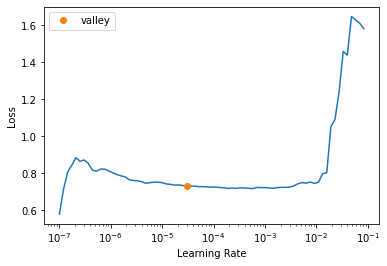

In [ ]:
lr = tuner.lr_find()

In [ ]:
lr.valley

tensor(3.0200e-05)

And now we can fit with the `OneCycle` policy:

In [ ]:
tuner.fit_one_cycle(3, float(lr.valley))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.573917,0.248175,0.912500,0.908854,01:34
1,0.335676,0.145416,0.967500,0.965969,01:38
2,0.146952,0.083523,0.981250,0.980494,01:35


A proper "save" and "prediction" technique will be added soon. For now we do support `tuner.save` and `tuner.load` for the weights:

In [ ]:
tuner.save('tuned_model')

Path('models/tuned_model.pth')

In [ ]:
tuner.load('tuned_model');